# Segmentação de Imagens de Trânsito

O objetivo deste exercicio é desenvolver um modelo de segmentação de imagens.

O dataset utilizado é o [CamSeq01](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/), que possui apenas 101 imagens de alta resolução. Cada pixel é rotulado como uma de 32 classes (carro, pedestre, etc).

Existem apenas 71 imagens de treino e 30 de teste.

A métrica oficial é a DICE.

Dica de como calculá-la: https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i

### Download do Dataset

In [ ]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip .
!unzip CamSeq01.zip

Skipping existing item: file://./CamSeq01.zip
Archive:  CamSeq01.zip
replace CamSeq01/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: CamSeq01/.DS_Store      
  inflating: __MACOSX/CamSeq01/._.DS_Store  
  inflating: CamSeq01/label_colors.txt  
  inflating: CamSeq01/readme.txt     
  inflating: CamSeq01/test/0016E5_08137.png  
  inflating: CamSeq01/test/0016E5_08123.png  
  inflating: CamSeq01/test/0016E5_08139_L.png  
  inflating: CamSeq01/test/0016E5_08095.png  
  inflating: CamSeq01/test/0016E5_08141_L.png  
  inflating: CamSeq01/test/0016E5_08143_L.png  
  inflating: CamSeq01/test/0016E5_08097.png  
  inflating: CamSeq01/test/0016E5_08135.png  
  inflating: CamSeq01/test/0016E5_08121.png  
  inflating: CamSeq01/test/0016E5_08109.png  
  inflating: CamSeq01/test/0016E5_08125.png  
  inflating: CamSeq01/test/0016E5_08131.png  
  inflating: CamSeq01/test/0016E5_08119.png  
  inflating: CamSeq01/test/0016E5_08147_L.png  
  inflating: CamSeq01/test/0016E5_08093.png  
  i

In [ ]:
! pip install neptune-client==0.9.1

In [ ]:
! pip install pytorch_lightning==1.2.10

In [ ]:
! pip install torchmetrics

In [ ]:
import glob
import random

from collections import OrderedDict
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import cv2

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

from torchmetrics import F1

import torchvision
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms.functional as TF

import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

import neptune.new as neptune

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

In [ ]:
label_file = open('/content/CamSeq01/label_colors.txt', 'r')
label_lines = label_file.readlines()

rgb_to_label = {}
label_to_rgb = {}

for i, line in enumerate(label_lines):
  line_split = line.split()
  line_split = tuple(map(int,line.split()[0:3]))
  rgb_to_label[line_split] = i
  label_to_rgb[i] = line_split

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, inputs, targets, rgb_to_label, label_to_rgb):
        self.inputs = inputs
        self.targets = targets
        self.rgb_to_label = rgb_to_label 
        self.label_to_rgb = label_to_rgb
    
    def map_to_label(self, img):
        img_mapped = torch.empty(img.shape[0],img.shape[1],1, dtype=torch.long)

        for m in self.rgb_to_label:
            idx = np.all((img == m), axis = 2)
            img_mapped[idx] = torch.tensor(self.rgb_to_label[m], dtype=torch.long)
        return img_mapped.squeeze()

    def map_to_rgb(self, img):
        img_mapped = np.empty([img.shape[0],img.shape[1],3], dtype=np.uint8)

        for m in self.label_to_rgb:
            idx = (img == m)
            img_mapped[idx] = np.array(self.label_to_rgb[m], dtype=np.uint8)
        return img_mapped

    def transform(self, input, target):
        toPILImage = transforms.ToPILImage()
        input = toPILImage(input)

        i, j, h, w = transforms.RandomCrop.get_params(input, output_size=(224, 224))
        input = TF.crop(input, i, j, h, w)
        target = TF.crop(target, i, j, h, w)

        if random.random() > 0.5:
            input = TF.hflip(input)
            target = TF.hflip(target)
        
        input = TF.to_tensor(input)

        return input, target

    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        input = cv2.imread(self.inputs[index], cv2.IMREAD_COLOR)
        target = cv2.imread(self.targets[index], cv2.IMREAD_COLOR)      
        
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        
        input = cv2.resize(input, (480,360), interpolation=cv2.INTER_NEAREST)
        target = cv2.resize(target, (480,360), interpolation=cv2.INTER_NEAREST)

        target_mapped = self.map_to_label(target)

        input, target_mapped = self.transform(input, target_mapped)

        return input, target_mapped
        

In [ ]:
batch_size = 6

inputs_train = sorted(glob.glob('/content/CamSeq01/train/' + '/*[!L].png'))
targets_train = sorted(glob.glob('/content/CamSeq01/train/' + '/*L.png'))
inputs_test = sorted(glob.glob('/content/CamSeq01/test/' + '/*[!L].png'))
targets_test = sorted(glob.glob('/content/CamSeq01/test/' + '/*L.png'))

dataset = SegmentationDataset(inputs=inputs_train, targets=targets_train, 
                              rgb_to_label=rgb_to_label, 
                              label_to_rgb=label_to_rgb)
test_dataset = SegmentationDataset(inputs=inputs_test, targets=targets_test, 
                                   rgb_to_label=rgb_to_label, 
                                   label_to_rgb=label_to_rgb)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [54, 12])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                                shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size,
                                shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1,
                                shuffle=False)

input, target = next(iter(train_dataloader))

print(f'input = shape: {input.shape}; type: {input.dtype}')
print(f'input = min: {input.min()}; max: {input.max()}')
print(f'target = shape: {target.shape}; type: {target.dtype}')
print(f'target = min: {target.min()}; max: {target.max()}')



input = shape: torch.Size([6, 3, 224, 224]); type: torch.float32
input = min: 0.0; max: 1.0
target = shape: torch.Size([6, 224, 224]); type: torch.int64
target = min: 1; max: 31


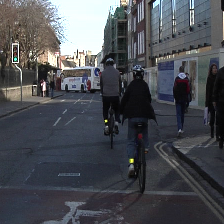

In [ ]:
image, target = test_dataset[1]

transforms.ToPILImage()(image)

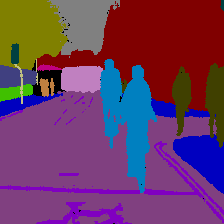

In [ ]:
transforms.ToPILImage()(test_dataset.map_to_rgb(target))

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=32):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
        return expand

In [ ]:
class DiceLoss():
    def __init__(self, smooth = 1e-7):
        self.smooth = smooth

    def __call__(self, logits, true):
        true_1_hot = torch.eye(logits.shape[1])[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()   
        true_1_hot = true_1_hot.type(logits.type())

        probas = torch.softmax(logits, dim=1)
        
        dims = (0,) + tuple(range(2, true.ndimension()))
        
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        
        dice_loss = (2. * intersection / (cardinality + self.smooth)).mean()
        
        return (1 - dice_loss)


In [ ]:
class SegmentationModule(LightningModule):
    def __init__(self, hparams, run):
        super().__init__()

        print(hparams)
        self.hparams = hparams
        run['hparams'] = hparams  # Log to Neptune.
        self.criterion = DiceLoss()

        # Carregando um modelo baseado na UNet
        self.model = UNet()

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch

        # predict da rede
        logits = self.model(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)

        # O PL sempre espera um retorno nomeado 'loss' da training_step.
        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        # predict da rede
        logits, preds = self.forward(x)
        
        # calcula a perda
        batch_losses = self.criterion(logits, y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        
        run['valid/loss'].log(avg_loss)

        self.log('valid_loss', avg_loss.item(), prog_bar=True)
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['test/loss'].log(avg_loss)

        self.log('test_loss', avg_loss.item())

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

In [ ]:
hparams = {
    'max_epochs': 50,
    'learning_rate': 0.01,
    'gpus': 1,
    'augmentation': False
}

run = neptune.init(project='davi/aula-8', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlMGU4YzQ5NC1kMzA1LTQ2ZWQtODQ1Ny01ZmQ4ZDc0NTg0M2QifQ==')
run["sys/tags"].add(f'aug:{hparams["augmentation"]}')


https://app.neptune.ai/davi/aula-8/e/AUL4-27


In [ ]:
pl_model = SegmentationModule(hparams=hparams, run=run)
trainer = Trainer(gpus=hparams['gpus'], max_epochs=hparams['max_epochs'])
trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'max_epochs': 50, 'learning_rate': 0.01, 'gpus': 1, 'augmentation': False}



  | Name  | Type | Params
-------------------------------
0 | model | UNet | 573 K 
-------------------------------
573 K     Trainable params
0         Non-trainable params
573 K     Total params
2.293     Total estimated model params size (MB)


1

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.901369035243988}
--------------------------------------------------------------------------------


[{'test_loss': 0.901369035243988}]

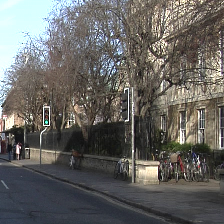

In [ ]:
transforms.ToPILImage()(test_dataset[1][0])

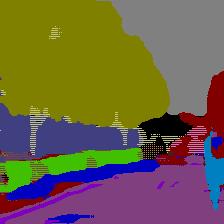

In [ ]:
pl_model.eval()
image, target = test_dataset[1]
pred = pl_model(image.unsqueeze(0).cuda())[1].permute(1,2,0).squeeze()
transforms.ToPILImage()(test_dataset.map_to_rgb(pred.cpu()))

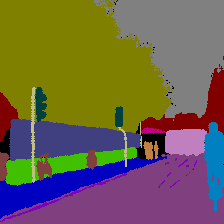

In [ ]:
transforms.ToPILImage()(test_dataset.map_to_rgb(target))